# Project Overview


As a supply chain analyst, I am tasked with forecasting monthly sales data to help plan the supply in line with demand for the company.

## The Business Problem

As the supply chain analyst, I am tasked with forecasting monthly sales data to synchronize supply with demand. This involves running the numbers through a time series forecasting model to aid decision-making and measure company performance. Currently, I am preparing to provide a forecast for the next 4 months of sales.

## Steps to Success

Step 1: Investigate and Prepare the Data

Look through the dataset to determine whether it is appropriate to use time series models. I will also take out a holdout sample for validation later on.

Step 2: Determine Trend, Seasonal, and Error Components

Graph the dataset and decompose the time series into its three main components: trend, seasonality, and error.

Step 3: Build the Models

Determinine the appropriate measurements to apply to my ARIMA and ETS models and describe the errors for both models.

Step 4: Forecast

Compare the in-sample error measurements for both models and evaluating error measurements for the holdout sample in my forecast. I will choose the best-fitting model and forecast the next four periods.

# STEP 1 - Investigate the data

Initial findings of the time series showed a complete series exhibiting the 4 key characteristics of
time series data. The series is over a continuous time interval, of sequential measurements
across that interval, using equal spacing between every two consecutive measurements and
each time unit within the time interval has at most one data point. 

Since I am to predict the monthly sales for the next 4 months, I would keep the last four months data as the test data set.

In [1]:
import pandas as pd

# Specify the file path
file_path = "monthly-sales.xlsx"  

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame
df.head()

,Month,Monthly Sales
0,2008-01,154000
1,2008-02,96000
2,2008-03,73000
3,2008-04,51000
4,2008-05,53000


In [2]:
df.shape

(69, 2)

In [3]:
df.isnull().sum()

Month            0
Monthly Sales    0
dtype: int64

In [4]:
# Generate summary statistics
df.describe()


,Monthly Sales
count,69.000000
mean,276623.188406
std,166398.891881
min,51000.000000
25%,154000.000000
50%,243000.000000
75%,347000.000000
max,711000.000000


In [5]:
df.tail()

,Month,Monthly Sales
64,2013-05,231000
65,2013-06,271000
66,2013-07,329000
67,2013-08,401000
68,2013-09,553000


In [6]:
df.dtypes

Month            object
Monthly Sales     int64
dtype: object

In [7]:
df['Date'] = pd.to_datetime(df['Month'])
df.head()

,Month,Monthly Sales,Date
0,2008-01,154000,2008-01-01
1,2008-02,96000,2008-02-01
2,2008-03,73000,2008-03-01
3,2008-04,51000,2008-04-01
4,2008-05,53000,2008-05-01


In [8]:
df.dtypes

Month                    object
Monthly Sales             int64
Date             datetime64[ns]
dtype: object

In [9]:
df.drop(columns=['Month'], inplace=True)
df.head()

,Monthly Sales,Date
0,154000,2008-01-01
1,96000,2008-02-01
2,73000,2008-03-01
3,51000,2008-04-01
4,53000,2008-05-01


## Split into train and test data sets

Since I would keep the last four months data as the test data set. The split will be given by:

test_data = df.iloc[-4:]

train_data =df.iloc[:-4] 


In [10]:
train_data = df.iloc[:-4]


# STEP 2 - Determine Trend, Seasonal, and Error Components



Determine the components using time series plots.

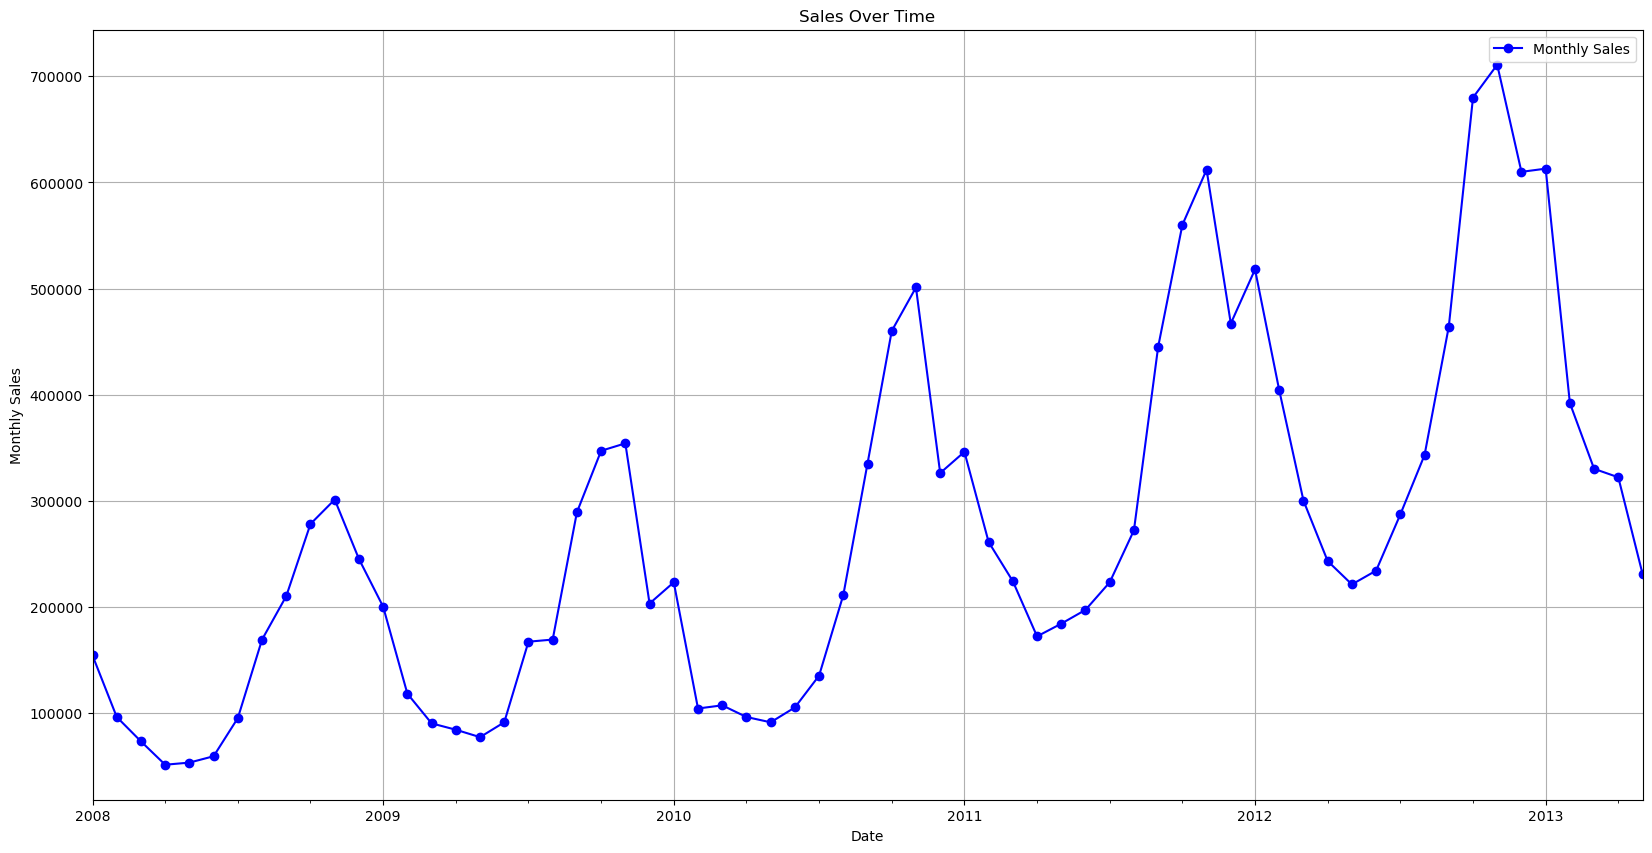

In [11]:
#Time series plot

import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (20,10)

# Plot a line graph
train_data.plot(x='Date', y='Monthly Sales', marker='o', color='b', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.title('Sales Over Time')

# Display the plot
plt.grid(True)
plt.show()

From my observation of the two graph above, the initial findings of the time series plot shows an upward rising trend with a regularly occurring spike in sales each year reported at the end of the year. 

This pattern shows that we have
seasonality in our time series. There are no patterns within the series suggesting cyclicity.

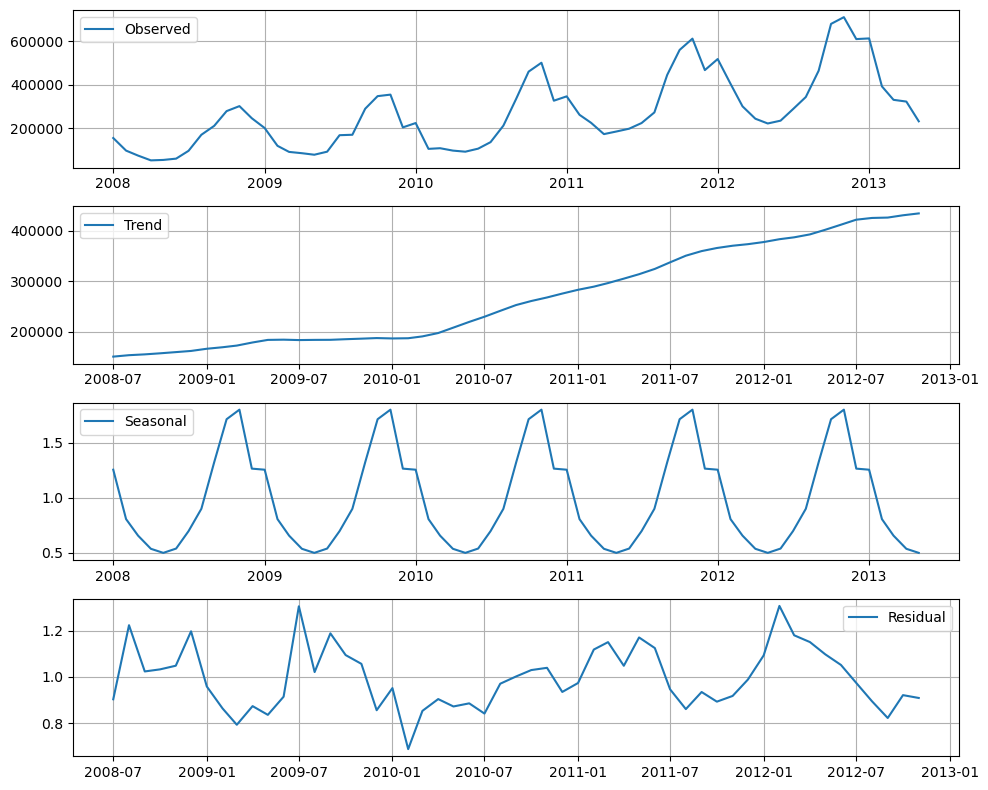

In [12]:
#Decomposition plot

from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data.set_index('Date', inplace=True)

# Set the frequency of the index to monthly ('M') or in this MS- Month start since the date is already in datetime format.
train_data.index.freq = 'MS'

# Decompose the time series into trend, seasonal, and residual components
#Set the model to multiplicative because the seasonal pattern increases in magnitude as the overall level of the time 
result = seasonal_decompose(train_data['Monthly Sales'], model='multiplicative')

# Plot the trend, seasonal, and residual components
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend()
plt.grid(True)

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.grid(True)

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()
plt.grid(True)

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Our trend line is confirmed as upward trending.


The seasonal portion shows that the regularly occurring spike in sales each year changes in
magnitude, ever so slightly. Having seasonality suggests that any ARIMA models used for
analysis will need seasonal differencing. The change in magnitude suggests that any ETS
models will use a multiplicative method in the seasonal component.

The error plot of the series presents a fluctuations between large and smaller errors as the time
series goes on. Since the fluctuations are not consistent in magnitude then we will apply error in
a multiplicative manner for any ETS models.


# STEP 3 - BUILD THE MODELS


On analyzing the  graphs, determine the appropriate measurements to apply to the ARIMA and ETS models and describe the errors for both models. 

## ETS Models 

Define model terms for ETS

Describe the in-sample errors. Use at least RMSE and MASE when examining results


From our decomposition plot we can obtain the necessary information to define our terms forthe ETS model.
Our trend line exhibits linear behavior so we will use an additive method.
The seasonality changes in magnitude each year so a multiplicative method is necessary.
The error changes in magnitude as the series goes along so a multiplicative method will beused.
This leaves us with an ETS(M, A, M) model.


In [14]:
train_data.head()

,Monthly Sales
Date,
2008-01-01,154000
2008-02-01,96000
2008-03-01,73000
2008-04-01,51000
2008-05-01,53000


In [15]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 
 



train_data = pd.Series(train_data['Monthly Sales']).astype('float64')
ets_model = ETSModel(train_data, error='mul', trend='add', seasonal = 'mul', 
                     damped_trend=True, seasonal_periods=12, initial_level=train_data.values.mean(), freq='MS')
ets_fitted = ets_model.fit()


In [16]:
# Print the summary of the model
print(ets_fitted.summary())

                                 ETS Results                                  
Dep. Variable:          Monthly Sales   No. Observations:                   65
Model:                      ETS(MAdM)   Log Likelihood                -758.979
Date:                Sun, 21 Apr 2024   AIC                           1555.958
Time:                        10:04:06   BIC                           1597.272
Sample:                    01-01-2008   HQIC                          1572.259
                         - 05-01-2013   Scale                            0.017
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999        nan        nan        nan         nan         nan
smoothing_trend      9.999e-05      0.047      0.002      0.998      -0.091       0.091
smoothing_season

###  Check for in-sample errors


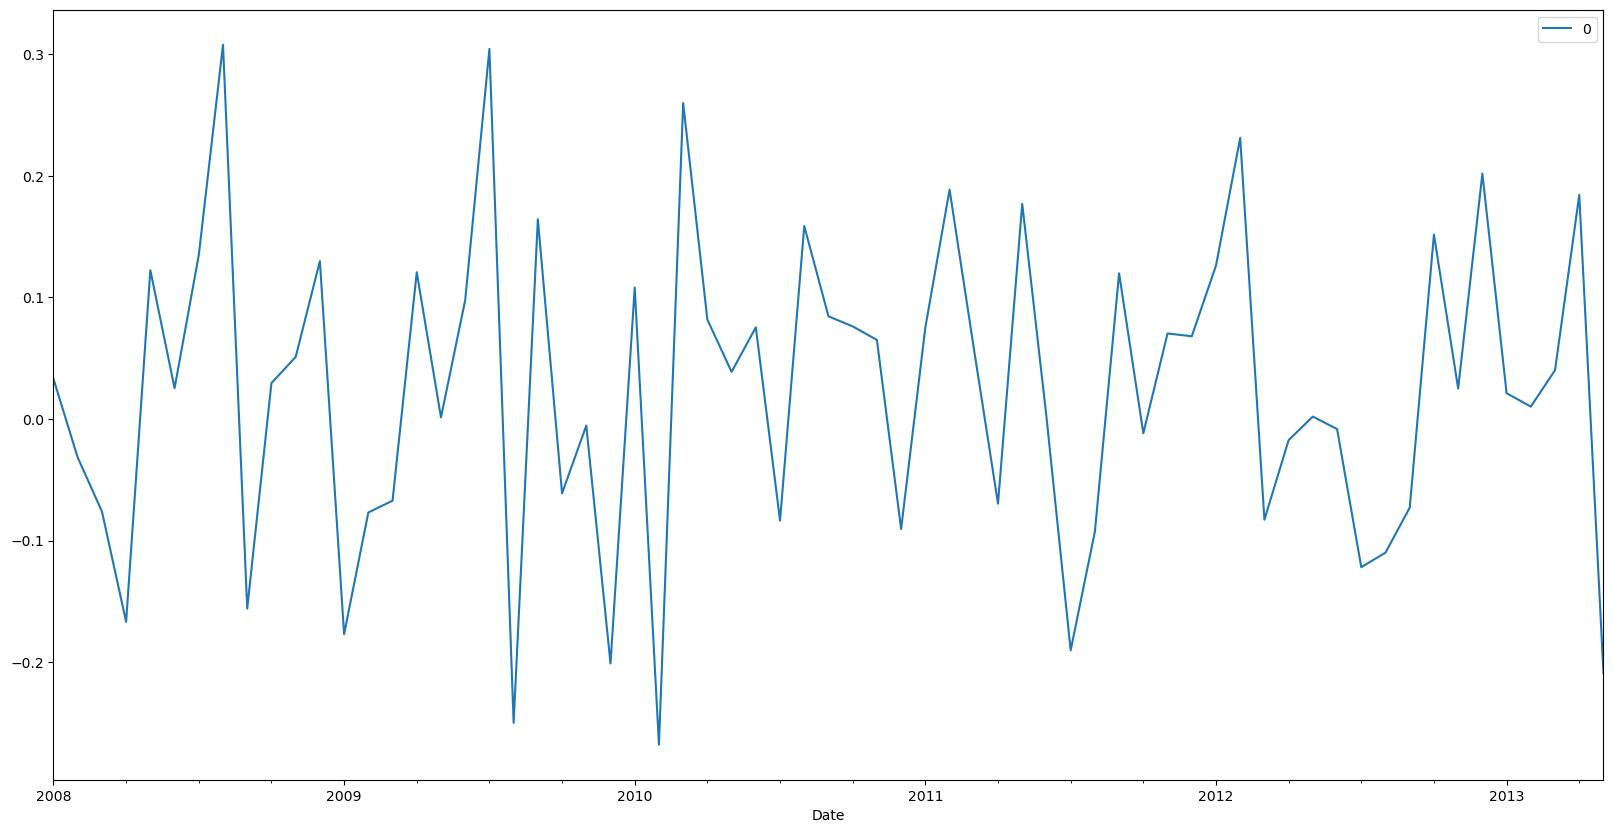

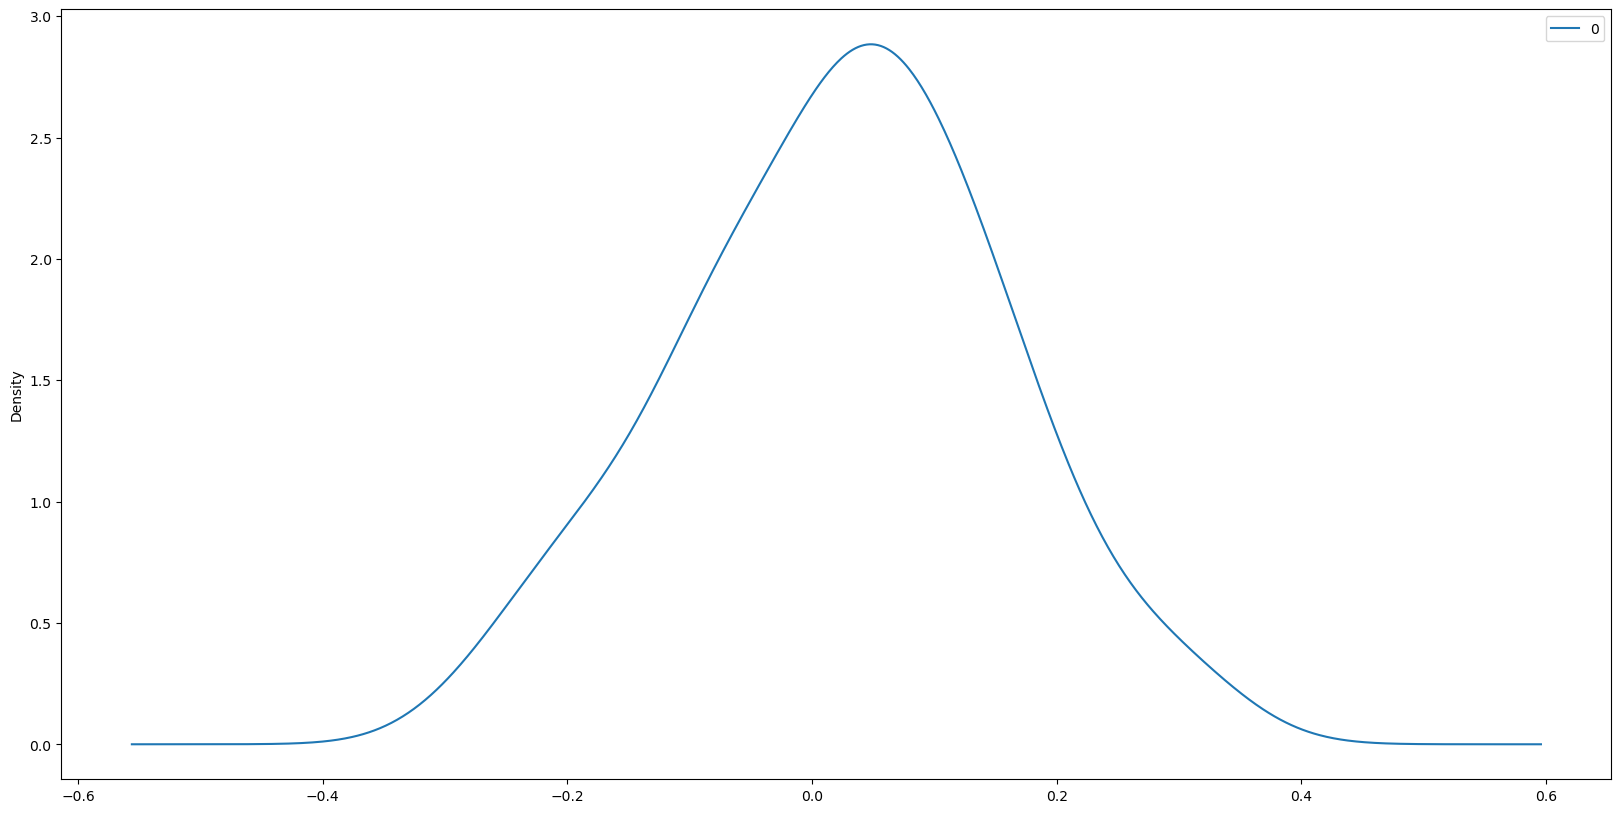

               0
count  65.000000
mean    0.023464
std     0.130538
min    -0.267967
25%    -0.072944
50%     0.029529
75%     0.119801
max     0.307865


In [17]:
residuals = pd.DataFrame(ets_fitted.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

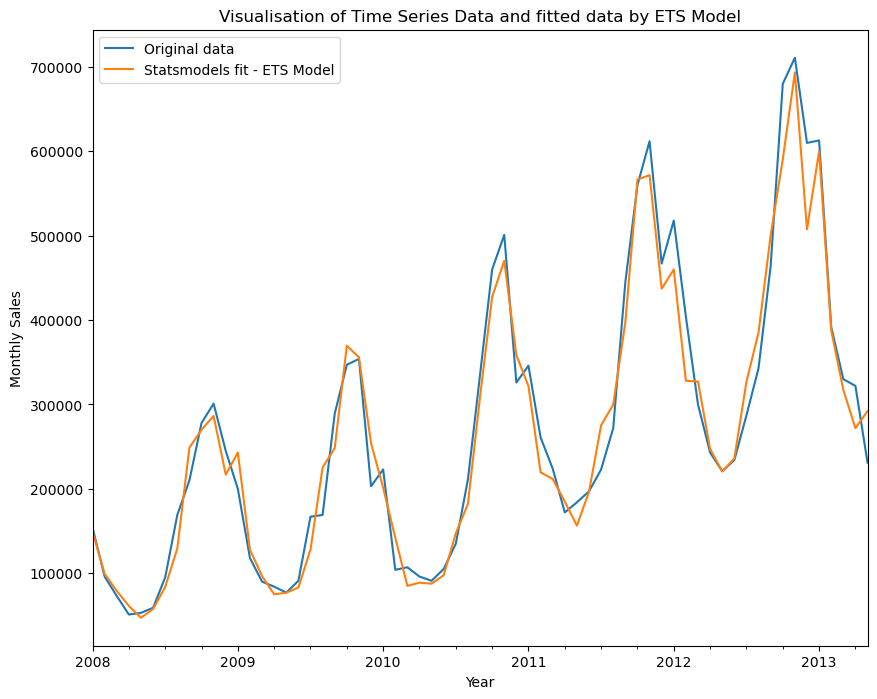

In [18]:
plt.figure(figsize=(10,8))
train_data.plot(label='Original data')
ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
plt.title('Visualisation of Time Series Data and fitted data by ETS Model')
plt.ylabel("Monthly Sales");
plt.xlabel("Year")
plt.legend();

In [22]:
import numpy as np

def mean_error(actual, forecasted):
    return np.mean(np.array(actual) - np.array(forecasted))

def mean_percentage_error(actual, forecasted):
    return np.mean((np.array(actual) - np.array(forecasted)) / np.array(actual)) * 100

def root_mean_squared_error(actual, forecasted):
    return np.sqrt(np.mean((np.array(actual) - np.array(forecasted)) ** 2))

def mean_absolute_error(actual, forecasted):
    return np.mean(np.abs(np.array(actual) - np.array(forecasted)))

def mean_absolute_percentage_error(actual, forecasted):
    return np.mean(np.abs((np.array(actual) - np.array(forecasted)) / np.array(actual))) * 100

def mean_absolute_scaled_error(actual, forecasted, naive_forecasted):
    return mean_absolute_error(actual, forecasted) / mean_absolute_error(actual, naive_forecasted)

In [23]:
#The Predicted values of the above ETS Model.
fc_ets= ets_fitted.fittedvalues 

# Extract the last observed value
last_observed_value = df['Monthly Sales'].iloc[-10]

actual_ets = train_data.values
forecast_ets = fc_ets.values
naive_forecast =  last_observed_value

me = mean_error(actual_ets, forecast_ets)
mpe = mean_percentage_error(actual_ets, forecast_ets)
rmse = root_mean_squared_error(actual_ets, forecast_ets)
mae = mean_absolute_error(actual_ets, forecast_ets)
mape = mean_absolute_percentage_error(actual_ets, forecast_ets)
mase = mean_absolute_scaled_error(actual_ets, forecast_ets, naive_forecast)

# Print the results
print("Mean Error (ME):", me)
print("Mean Percentage Error (MPE):", mpe)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Absolute Scaled Error (MASE):", mase)

Mean Error (ME): 6039.909801546869
Mean Percentage Error (MPE): 0.634963117600508
Root Mean Squared Error (RMSE): 33983.36179799487
Mean Absolute Error (MAE): 25891.61041554739
Mean Absolute Percentage Error (MAPE): 10.569011493674394
Mean Absolute Scaled Error (MASE): 0.07490118283014734


Two key components to look at are the RMSE, which shows the in-sample standard deviation, and the MASE which can be used to compare forecasts of different models.

From the errors displayed above:

The RMSE measures the average deviation of the forecasted values from the actual observed values.
In this case, the RMSE value of approximately 33983.36 indicates that, on average, the forecasted values deviate from the actual observed values by approximately 33983.36 units.


The MASE compares the performance of a forecasting model to a naive baseline model (e.g., simple average or naive forecast).
A value of 0.0749 indicates that the forecasting model's performance is approximately 7.49% as accurate as the naive baseline model in predicting the future values.
A lower MASE value suggests better forecasting accuracy relative to the baseline model.

## ARIMA MODEL

Define the model terms for the ARIMA model
Describe the in-sample errors. Use at least RMSE and MASE when examining results.
Regraph ACF and PACF for both the Time Series and Seasonal Difference and include these graphs in your answer and show that the graphs have no autocorrelated lag anymore.

###  Check for stationarity And Make the data stationary if it doesn't exist

The decomposition plot displayed , the provided dataset seems to have seasonality and linear Trend, that implies that the data is not stationary. Using the Augmented Dickey Fuller test, we confirm the stationarity of the time series data with the expected results.

In a non-stationary time series data, the Augmented Dickey-Fuller (ADF) test is expected to yield results that fail to reject the null hypothesis. Here are the expected results:

High p-value: The p-value associated with the ADF test statistic is expected to be greater than a chosen significance level (e.g., 0.05 or 0.01). This indicates that there is insufficient evidence to reject the null hypothesis.
Non-significant test statistic: The ADF test statistic itself is expected to be less negative (or closer to zero) than critical values at the chosen significance level. This further supports the lack of evidence against the null hypothesis.

In [25]:
# Augmented Dickey Fuller test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train_data.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.613050
p-value: 0.997896


The p-value is very high (0.99), indicating that there is weak evidence against the null hypothesis of non-stationarity. Typically, a p-value greater than 0.05 suggests that we fail to reject the null hypothesis. Therefore, in this case, the test does not provide evidence to suggest that the time series is stationary.

In summary, based on the high p-value, we do not have sufficient evidence to reject the null hypothesis of non-stationarity. Thus, the time series data is likely non-stationary.

### Since the data is non-stationary, I difference the points to make it stationary. I will conduct first, second , third differencing till the time series data is stationary.

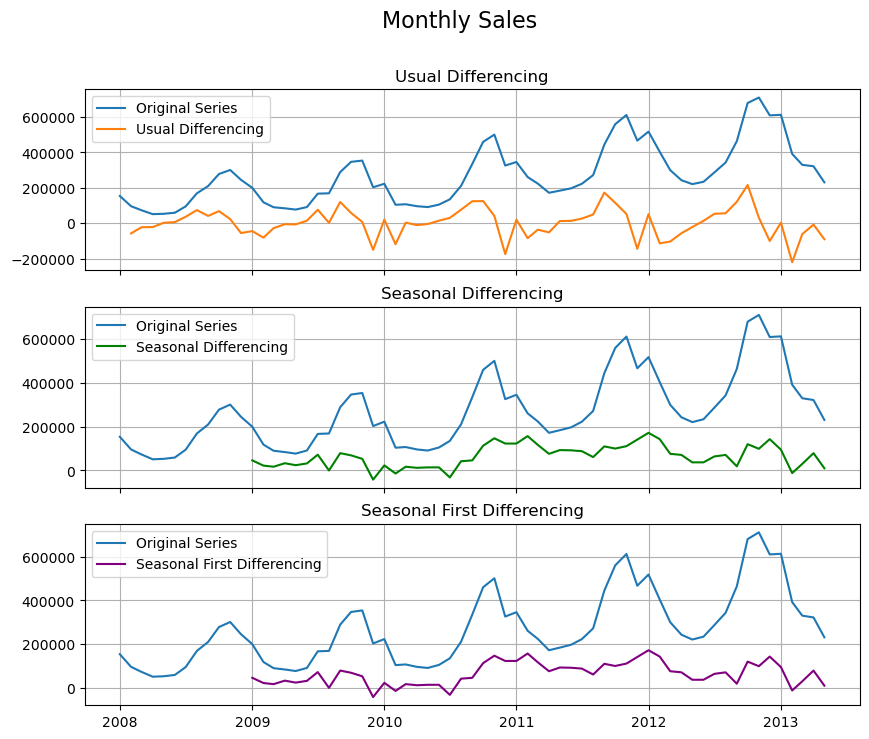

In [26]:
# Plot
fig, axes = plt.subplots(3, 1, figsize=(10,8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(train_data, label='Original Series')
axes[0].plot(train_data.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True)
train_data_diff = train_data.diff(1)

# Seasonal Differencing
axes[1].plot(train_data, label='Original Series')
axes[1].plot(train_data.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True)

# Seasonal first differencing 
axes[2].plot(train_data, label='Original Series')
axes[2].plot(train_data.diff(12), label='Seasonal First Differencing', color='purple')
axes[2].set_title('Seasonal First Differencing')
axes[2].legend(loc='upper left', fontsize=10)
axes[2].grid(True)

plt.suptitle('Monthly Sales', fontsize=16)
plt.show()

In [27]:
# Augmented Dickey Fuller test for Seasonal First Differencing Data 
seasonal_first_differencing = train_data_diff.diff(12)
result_seasonal_first_diff = adfuller(seasonal_first_differencing.dropna())
print('ADF Statistic for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[0])
print('p-value for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[1])

ADF Statistic for Seasonal First Differencing: -9.4464
p-value for Seasonal First Differencing: 0.0000


As you can see from the third plot, the original time series data is changed a stationary data after seasonal first differencing. This fact can be also confirmed by the p-value of Augmented Dickey Fuller test. Taking the seasonal first difference has now made our data stationary. Next, I find the optimal parameters based on the Time Series ACF and PACF graphs.


###  Plot the ACF and PACF Graphs

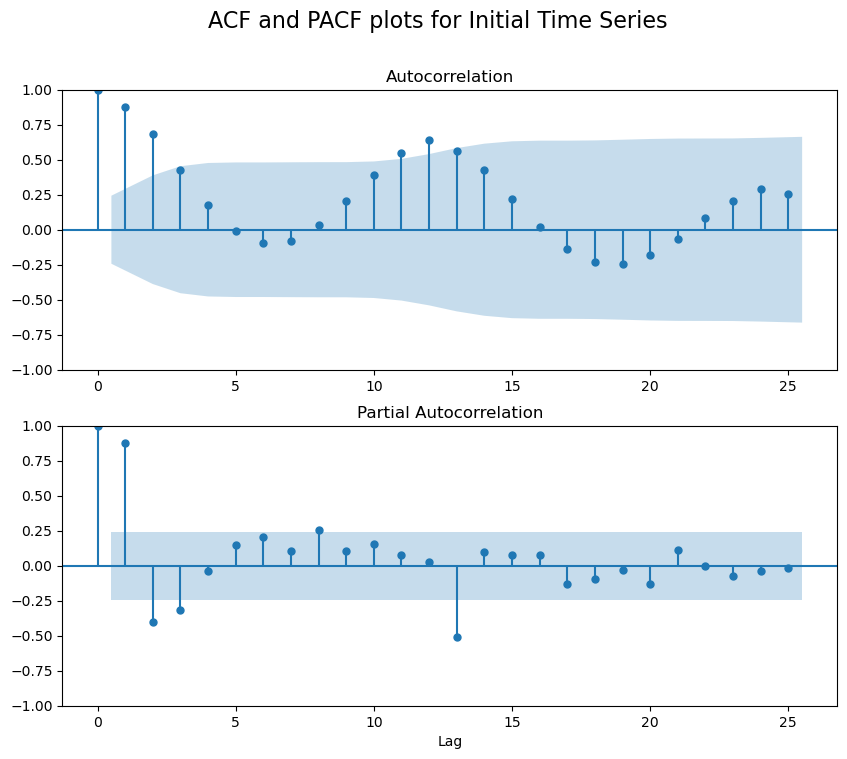

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(train_data,  lags=25, ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(train_data, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Initial Time Series', fontsize=16)
plt.show()

A good time series data for forecasting typically exhibits certain characteristics when analyzed through autocorrelation function (ACF) and partial autocorrelation function (PACF) plots:

ACF Plot: In a good time series data, the ACF plot gradually decreases and ideally cuts off after a certain lag. This indicates that there is no significant autocorrelation beyond that lag.
The ACF plot may also show some periodicity or seasonality, which is common in many time series datasets.
Ideally, there should be no significant spikes in the ACF plot, suggesting that the series is stationary.


PACF Plot: In a good time series data, the PACF plot typically shows a sharp cutoff after a certain lag, indicating that most of the autocorrelation is explained by the preceding lags.
If there is a significant spike at a particular lag in the PACF plot, it suggests that there is a strong relationship between the observation and its lagged values at that specific lag.
Overall, a good time series data for forecasting should exhibit characteristics of stationarity, which include constant mean and variance over time, as well as a stable autocovariance structure. The ACF and PACF plots help to identify these characteristics and guide the selection of appropriate forecasting models such as ARIMA or SARIMA.


The ACF plot above presents slowly decaying serial correlations towards 0 with increases at the seasonal lags. Since serial correlation is high I will need to seasonally difference the series.

## Seasonal Difference ACF and PACF

Text(0.5, 0, 'Lag')

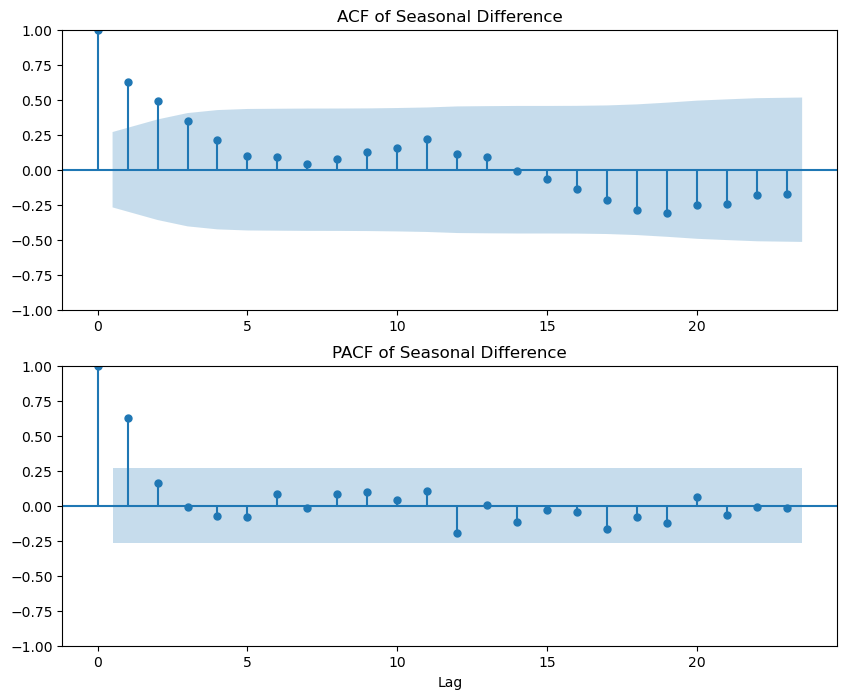

In [29]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Compute the seasonal difference
seasonal_diff = train_data.diff(12)

# Plot the ACF and PACF of the seasonal difference
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot
plot_acf(seasonal_diff.dropna(), ax=axes[0], lags=23)
axes[0].set_title('ACF of Seasonal Difference')

# PACF plot
plot_pacf(seasonal_diff.dropna(), ax=axes[1], lags=23)
axes[1].set_title('PACF of Seasonal Difference')
plt.xlabel('Lag')

    

The seasonal difference presents similar ACF and PACF patterns as the initial plots, without differencing, only slightly less correlated. In order to remove correlation we will need to difference further.

## Seasonal First Difference ACF and PACF

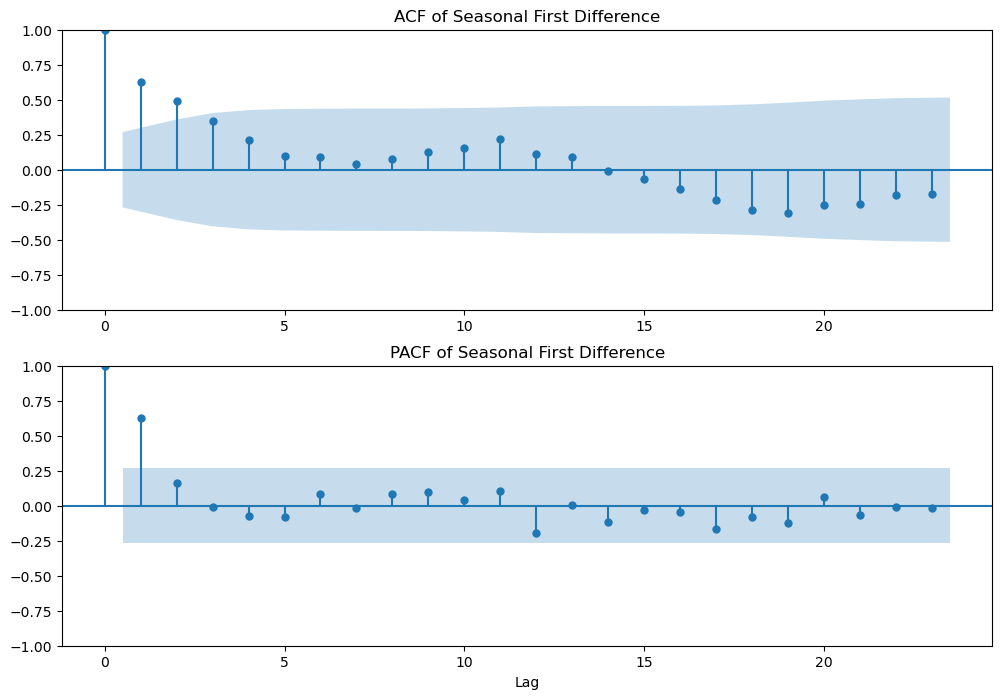

In [30]:
# Compute the seasonal first difference
seasonal_first_diff = train_data.diff(12)

# Plot ACF and PACF of the seasonal first difference
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(seasonal_first_diff.dropna(), ax=axes[0], lags=23, title='ACF of Seasonal First Difference')
plot_pacf(seasonal_first_diff.dropna(), ax=axes[1], lags=23, title='PACF of Seasonal First Difference')
plt.xlabel('Lag')
plt.show()

The seasonal first difference of the series has removed most of the significant lags from the ACF and PACF. It seems no more need for further differencing. The remaining correlation can be considered for using autoregressive and moving average terms. Therefore, the differencing terms will be d(1) and D(1).

The ACF plot shows a strong negative correlation at lag-1 which is confirmed in the PACF. This suggests an MA(1) model since there is only 1 significant lag. The seasonal lags (lag 12, 24, etc.) in the ACF and PACF do not have any significant correlation so there will be no need for seasonal autoregressive or moving average terms.

Therefore, the model terms for my ARIMA model are: ARIMA(0, 1, 1)(0, 1, 0)[12]. Note that the ACF and PACF results for the ARIMA(0, 1, 1)(0, 1, 0)[12] model shows no significantly correlated lags suggesting no need for adding additional AR() or MA() terms.

Note: The lag can also be noticed when plotting the ACF and PACF plots, seeind as the max lag permitted was 23 (i.e < 24, per each 12 season).


Error Terms:
The ACF and PACF results for the ARIMA(0, 1, 1)(0, 1, 0)[12] model shows no significantly
correlated lags suggesting no need for adding additional AR() or MA() terms.

## Define seasonal ARIMA model

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
sarima_model = SARIMAX(train_data, order=(0, 1, 1), seasonal_order=(0, 1, 0, 12), trend = 't', freq = 'MS', 
                       enforce_stationarity=False, 
                        enforce_invertibility=False)

# Fit the SARIMA model to the data
sarima_fit = sarima_model.fit()

# Print the summary of the model
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                       Monthly Sales   No. Observations:                   65
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -602.879
Date:                             Sun, 21 Apr 2024   AIC                           1211.757
Time:                                     10:10:02   BIC                           1217.493
Sample:                                 01-01-2008   HQIC                          1213.942
                                      - 05-01-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -22.1131     83.683     -0.264      0.792    -186.128     141.902
ma.L1         -0.3884      

### Check for insample Errors


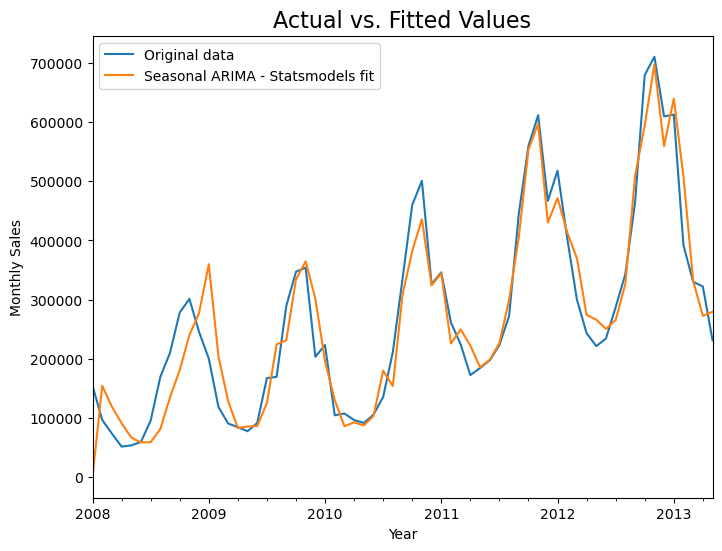

In [35]:
# Compare the Original Time Series and Fitted values 
train_data.plot(label='Original data',figsize=(8,6))
sarima_fit.fittedvalues.plot(label='Seasonal ARIMA - Statsmodels fit')
plt.ylabel("Monthly Sales");
plt.xlabel("Year")
plt.title('Actual vs. Fitted Values', fontsize= 16)
plt.legend();

In [36]:
#Evaluating In-Sample Accuracy (Seasonal ARIMA)

forecast_sarima = sarima_fit.predict().values
actual_sarima = train_data.values
naive_forecast =  last_observed_value

me = mean_error(actual_sarima, forecast_sarima)
mpe = mean_percentage_error(actual_sarima, forecast_sarima)
rmse = root_mean_squared_error(actual_sarima, forecast_sarima)
mae = mean_absolute_error(actual_sarima, forecast_sarima)
mape = mean_absolute_percentage_error(actual_sarima, forecast_sarima)
mase = mean_absolute_scaled_error(actual_sarima, forecast_sarima, naive_forecast)

# Print the results
print("Mean Error (ME):", me)
print("Mean Percentage Error (MPE):", mpe)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Absolute Scaled Error (MASE):", mase)

Mean Error (ME): 1666.8658799630546
Mean Percentage Error (MPE): -3.478532811403296
Root Mean Squared Error (RMSE): 52807.84088716308
Mean Absolute Error (MAE): 39576.055457011535
Mean Absolute Percentage Error (MAPE): 20.196629377076096
Mean Absolute Scaled Error (MASE): 0.11448856667879077



Two key components to look at are the RMSE, which shows the in-sample standard deviation,
and the MASE which can be used to compare forecasts of different models.

We can see that our variance is about 52807  units around the mean.

The MASE shows a fairly strong forecast at 11% with its value falling well below the generic 1.00,
the commonly accepted MASE threshold for model accuracy.

# STEP 4 - FORECAST THE MODEL

## Compare the forecast of the test data using both ARIMA and ETS models

In [41]:
test_data = df.iloc[-4:]
test_data.set_index('Date', inplace=True)
#test_data.reset_index(inplace=True)
test_data

,Monthly Sales
Date,
2013-06-01,271000
2013-07-01,329000
2013-08-01,401000
2013-09-01,553000


In [46]:
#Forecast using the ETS Model
ets_forecast_values = ets_fitted.forecast(steps=len(test_data))

# Add the forecasted values to the test data DataFrame
test_data['Forecast'] = ets_forecast_values

# Print the test data with forecasted values
print(test_data)

            Monthly Sales       Forecast
Date                                    
2013-06-01         271000  246528.385202
2013-07-01         329000  344190.602348
2013-08-01         401000  461863.715607
2013-09-01         553000  673378.438128


C:\Users\Prisca\AppData\Local\Temp\ipykernel_13512\3126189440.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Forecast'] = ets_forecast_values


In [47]:
# Forecast using the ARIMA model
sarima_forecast_values = sarima_fit.forecast(steps=len(test_data))

# Add the forecasted values to the test data DataFrame
test_data['Forecast'] = sarima_forecast_values

# Print the test data with forecasted values
print(test_data)

            Monthly Sales       Forecast
Date                                    
2013-06-01         271000  261314.483431
2013-07-01         329000  312855.017366
2013-08-01         401000  367373.438179
2013-09-01         553000  486869.745870


C:\Users\Prisca\AppData\Local\Temp\ipykernel_13512\1218030339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Forecast'] = sarima_forecast_values


In [48]:
# Compare results 

holdout_results = pd.DataFrame({'Actual': test_data['Monthly Sales'], 
                                 'ETS_Forecast': ets_forecast_values, 
                                 'ARIMA_Forecast': sarima_forecast_values }, 
                               index = test_data.index) 
holdout_results

,Actual,ETS_Forecast,ARIMA_Forecast
Date,,,
2013-06-01,271000,246528.385202,261314.483431
2013-07-01,329000,344190.602348,312855.017366
2013-08-01,401000,461863.715607,367373.438179
2013-09-01,553000,673378.438128,486869.745870


## Errors Comparison - In Sample measures vs Residual errors

First we find the residual errors - Residual error refers to the difference between the observed values and the values predicted by the model. It represents the model's inability to explain all of the variability in the data.

In [71]:


naive_forecast =  last_observed_value

#ETS Model 
me_ets_hos = mean_error(test_data['Monthly Sales'], holdout_results['ETS_Forecast'])
mpe_ets_hos = mean_percentage_error(test_data['Monthly Sales'], holdout_results['ETS_Forecast'])
rmse_ets_hos = root_mean_squared_error(test_data['Monthly Sales'], holdout_results['ETS_Forecast'])
mae_ets_hos = mean_absolute_error(test_data['Monthly Sales'], holdout_results['ETS_Forecast'])
mape_ets_hos = mean_absolute_percentage_error(test_data['Monthly Sales'], holdout_results['ETS_Forecast'])
mase_ets_hos = mean_absolute_scaled_error(test_data['Monthly Sales'],naive_forecast, holdout_results['ETS_Forecast'])


# Print the results
print('Holdout-Sample Error Measures of ETS Models:')
print(' ')
print("Mean Error (ME): {:.2f}".format(me_ets_hos))
print("Mean Percentage Error (MPE): {:.2f}".format(mpe_ets_hos))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse_ets_hos))
print("Mean Absolute Error (MAE): {:.2f}".format(mae_ets_hos))
print("Mean Absolute Percentage Error (MAPE): {:.2f}".format(mape_ets_hos))
print("Mean Absolute Scaled Error (MASE): {:.2f}".format(mase_ets_hos))
print(' ')
print(' ')

# (Seasonal) ARIMA Model
me_sarima_hos = mean_error(test_data['Monthly Sales'], holdout_results['ARIMA_Forecast'])
mpe_sarima_hos = mean_percentage_error(test_data['Monthly Sales'], holdout_results['ARIMA_Forecast'])
rmse_sarima_hos = root_mean_squared_error(test_data['Monthly Sales'], holdout_results['ARIMA_Forecast'])
mae_sarima_hos = mean_absolute_error(test_data['Monthly Sales'], holdout_results['ARIMA_Forecast'])
mape_sarima_hos = mean_absolute_percentage_error(test_data['Monthly Sales'], holdout_results['ARIMA_Forecast'])
mase_sarima_hos = mean_absolute_scaled_error(test_data['Monthly Sales'], naive_forecast,holdout_results['ARIMA_Forecast'])


# Print the results
print('Holdout-Sample Error Measures of SARIMA Models:')
print(' ')
print("Mean Error (ME): {:.2f}".format(me_sarima_hos))
print("Mean Percentage Error (MPE): {:.2f}".format(mpe_sarima_hos))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse_sarima_hos))
print("Mean Absolute Error (MAE): {:.2f}".format(mae_sarima_hos))
print("Mean Absolute Percentage Error (MAPE): {:.2f}".format(mape_sarima_hos))
print("Mean Absolute Scaled Error (MASE): {:.2f}".format(mase_sarima_hos))


Holdout-Sample Error Measures of ETS Models:
 
Mean Error (ME): -42990.29
Mean Percentage Error (MPE): -8.13
Root Mean Squared Error (RMSE): 68965.53
Mean Absolute Error (MAE): 55226.09
Mean Absolute Percentage Error (MAPE): 12.65
Mean Absolute Scaled Error (MASE): 4.01
 
 
Holdout-Sample Error Measures of SARIMA Models:
 
Mean Error (ME): 31396.83
Mean Percentage Error (MPE): 7.21
Root Mean Squared Error (RMSE): 38270.18
Mean Absolute Error (MAE): 31396.83
Mean Absolute Percentage Error (MAPE): 7.21
Mean Absolute Scaled Error (MASE): 7.05


##### ETS MODEL IN-SAMPLE ERRORS

Mean Error (ME): 6039.909801546869

Mean Percentage Error (MPE): 0.634963117600508

Root Mean Squared Error (RMSE): 33983.36179799487

Mean Absolute Error (MAE): 25891.61041554739

Mean Absolute Percentage Error (MAPE): 10.569011493674394

Mean Absolute Scaled Error (MASE): 0.07490118283014734



##### ARIMA MODEL IN-SAMPLE ERRORS


Mean Error (ME): 1666.8658799630546

Mean Percentage Error (MPE): -3.478532811403296

Root Mean Squared Error (RMSE): 52807.84088716308

Mean Absolute Error (MAE): 39576.055457011535

Mean Absolute Percentage Error (MAPE): 20.196629377076096

Mean Absolute Scaled Error (MASE): 0.11448856667879077

#### Comparing In-sample and residual errors
In comparing errors, usually the lower the better.

When fitting a forecasting model we can use a series of identifiers that help us choose the best model.

When comparing the two in-sample error measures we used, we see that the ETS Model has lower error values than the ARIMA model. Further investigation shows that the MPE and ME of the ARIMA model are lower than the ETS Model. This suggests that, on average, the ARIMA model misses its forecast by a lesser amount.

When looking at the residual errors, we see that the ARIMA model has better predictive qualities in just about every metric. Hence, the ARIMA model is the best choice.

Note that when comparing Mean Errors, the absolute values are what is considered.

Therefore for our predicting needs, the SARIMA model is the best fit

## Forecast for the next 4 months of Sales

Previously, I concluded that the Seasonal ARIMA model shows better performance in terms of prediction. Now, I will forecast for the next four month sales using all the time series data based on the same Seasonal ARIMA model. First, I diagnose the stationarity of the entire time series data. Then the forecast results are calculated using 95% and 80% confidence intervals.

In [60]:
#always set index when you need to
df.set_index('Date', inplace=True)


In [64]:
#always set frequency after setting date index
df.index.freq = 'MS'

In [66]:
# Seasonal ARIMA Model for Forecasting 
sarima_model_final = sm.tsa.statespace.SARIMAX(df, order=(0, 1, 1), 
                                             seasonal_order=(0,1,0,12), trend = 't',freq = 'MS', 
                                             enforce_stationarity=False, enforce_invertibility=False)
# FIt Model
sarima_fitted_final = sarima_model_final.fit()


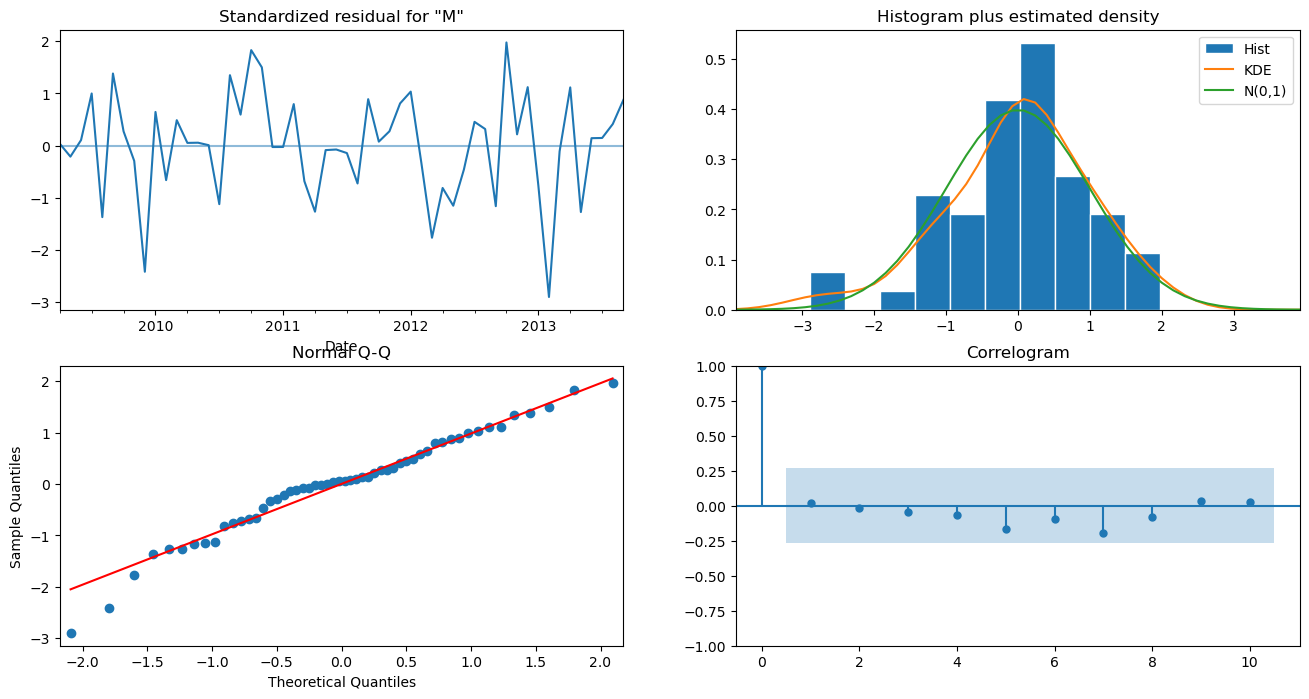

In [67]:
sarima_fitted_final.plot_diagnostics(figsize=(16, 8))
plt.show()

In [70]:
#Forecast results using 95% and 80% confidence intervals:

fcast = sarima_fitted_final.get_forecast(4)
forecast_results = pd.DataFrame({'forecast_mean': fcast.predicted_mean, 
                                 'forecast_high_95': fcast.conf_int(alpha= 0.05).iloc[:,1], 
                                 'forecast_high_80': fcast.conf_int(alpha= 0.20).iloc[:,1], 
                                 'forecast_low_80': fcast.conf_int(alpha= 0.20).iloc[:,0], 
                                 'forecast_low_95': fcast.conf_int(alpha= 0.05).iloc[:,0], 
                                }) 
forecast_results.index = pd.date_range(start=forecast_results.index[0] , periods=len(forecast_results), freq='MS')
forecast_results

,forecast_mean,forecast_high_95,forecast_high_80,forecast_low_80,forecast_low_95
2013-10-01,756469.982842,837662.052683,809558.623774,703381.341910,675277.913001
2013-11-01,788700.836872,884287.127315,851201.352763,726200.320980,693114.546428
2013-12-01,688949.274530,797029.456046,759619.106690,618279.442371,580869.093014
2014-01-01,693215.295818,812487.724955,771203.345340,615227.246296,573942.866681


Text(0.5, 1.0, 'Actual and Forecast Values')

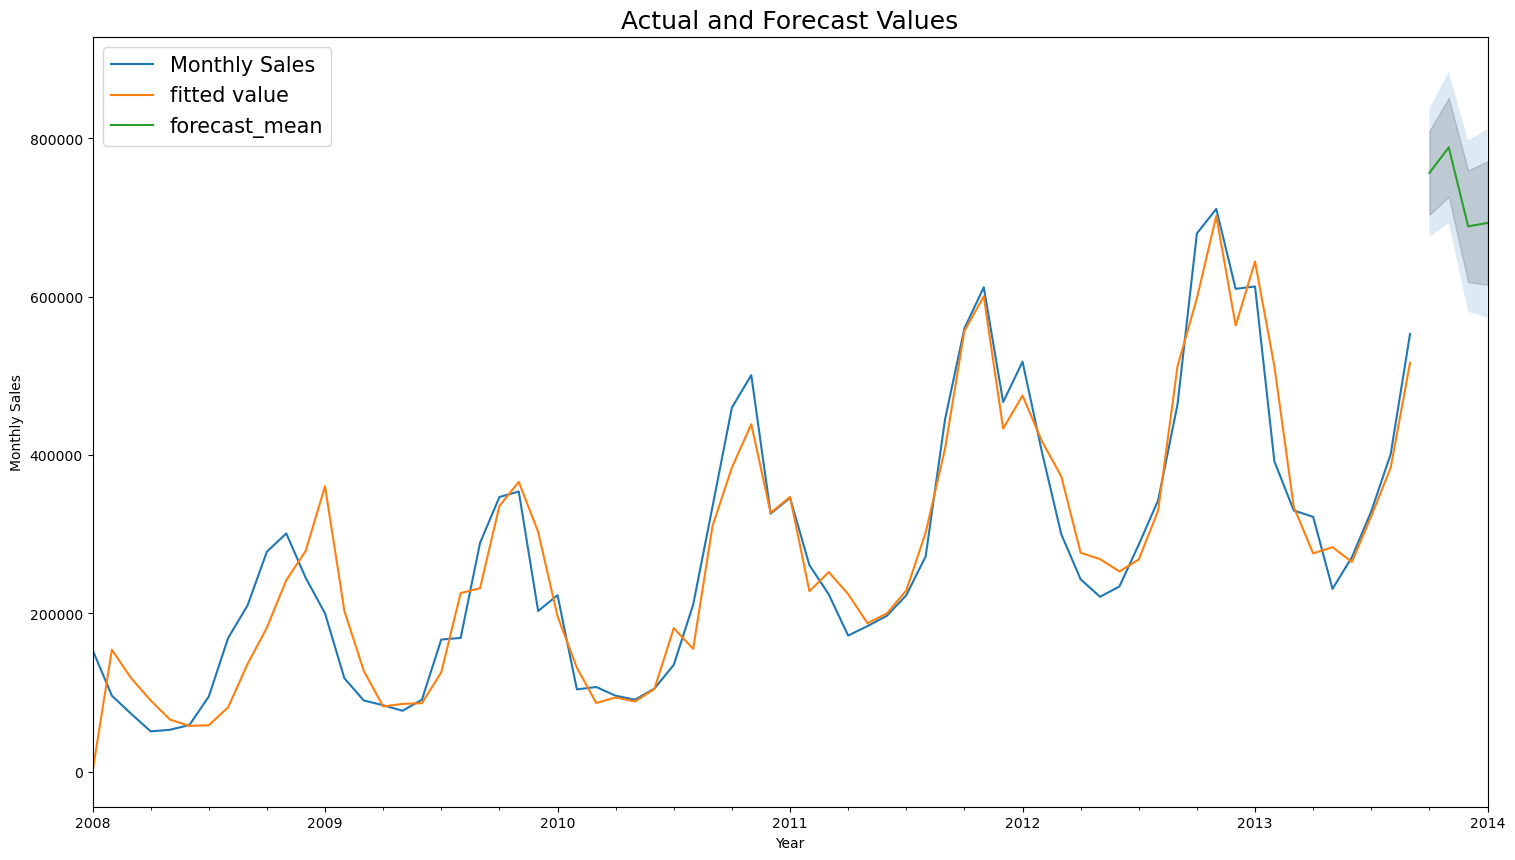

In [69]:
# Visualize the forecasted results 

df.plot(figsize=(18,10))
sarima_fitted_final.fittedvalues.plot(label = 'fitted value')
forecast_results.forecast_mean.plot()
upper_series_80 = forecast_results.forecast_high_80
lower_series_80 = forecast_results.forecast_low_80
upper_series_95 = forecast_results.forecast_high_95
lower_series_95 = forecast_results.forecast_low_95

plt.fill_between(upper_series_80.index, 
                 lower_series_80, 
                 upper_series_80, 
                 color='k', alpha=.15)

plt.fill_between(lower_series_95.index, 
                 lower_series_95, 
                 upper_series_95, 
                 color= None, linestyle ='--', alpha=.15)
plt.legend(loc = 'upper left', fontsize =15)
plt.xlabel('Year')
plt.ylabel('Monthly Sales')
plt.title('Actual and Forecast Values', fontsize = 18)